# Обработка текста

## Загрузка данных и просмотр информации

In [249]:
import numpy as np
import pandas as ps
import seaborn as sb
import matplotlib.pyplot as mpl
# Библиотека для анализа текста
import nltk
# Подгрузка стандартного списка стоп слов
nltk.download('stopwords')
from nltk.corpus import stopwords, WordListCorpusReader
import warnings
import re
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, f1_score, confusion_matrix
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\VPR\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Загрузка датасета

In [250]:
path: str = './data/dataset.csv'
df: ps.DataFrame = ps.read_csv(path)

Проверка, что все загрузилось

In [251]:
df.head()

,category,text
0,Благоустройство территории,На трассе Нижнекамск-Чистополь в лесополосе у ...
1,Благоустройство территории,Во дворе дома Ленинградская 29 отсутствуют пар...
2,Содержание и ремонт муниципальных дорог,Добрый день! Не осуществляется уборка снега в ...
3,Благоустройство территории,Добрый день! Не осуществляется вывоз мусора с ...
4,Содержание и ремонт муниципальных дорог,на данном участке проезжей части от ул.Халитов...


Посмотрим размер данных

In [252]:
df.shape

(29022, 2)

Просмотр базовой информации, сколько пропусков в данных и какие типы

In [253]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29022 entries, 0 to 29021
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   category  28015 non-null  object
 1   text      28015 non-null  object
dtypes: object(2)
memory usage: 453.6+ KB


Уточнение того, что количество пропусков совпадает в обеих колонках

In [254]:
df.isna().sum()

category    1007
text        1007
dtype: int64

Скорее всего есть полностью или частично пустые строки

Удалим их

In [255]:
df.dropna(axis=0, inplace=True)

Проверка результата, что колонки удалились

In [256]:
df.isna().sum()

category    0
text        0
dtype: int64

In [257]:
df.text[1850]

'подводка электрического кабеля осуществляется подземным способом, в данном случае воздушная подводка'

## Подготовка данных

Посмотрим количество категорий

In [258]:
df.category.value_counts()

Благоустройство территории                                                              12967
Содержание и ремонт муниципальных дорог                                                  6948
Нарушение в наружной рекламе                                                             2079
Организация дорожного движения                                                           2040
Общественный транспорт                                                                    936
Бездомные животные                                                                        726
Поликлиники и больницы                                                                    524
Парки и скверы                                                                            406
Cвалки                                                                                    335
Мобильная связь                                                                           200
Воздух                                                      

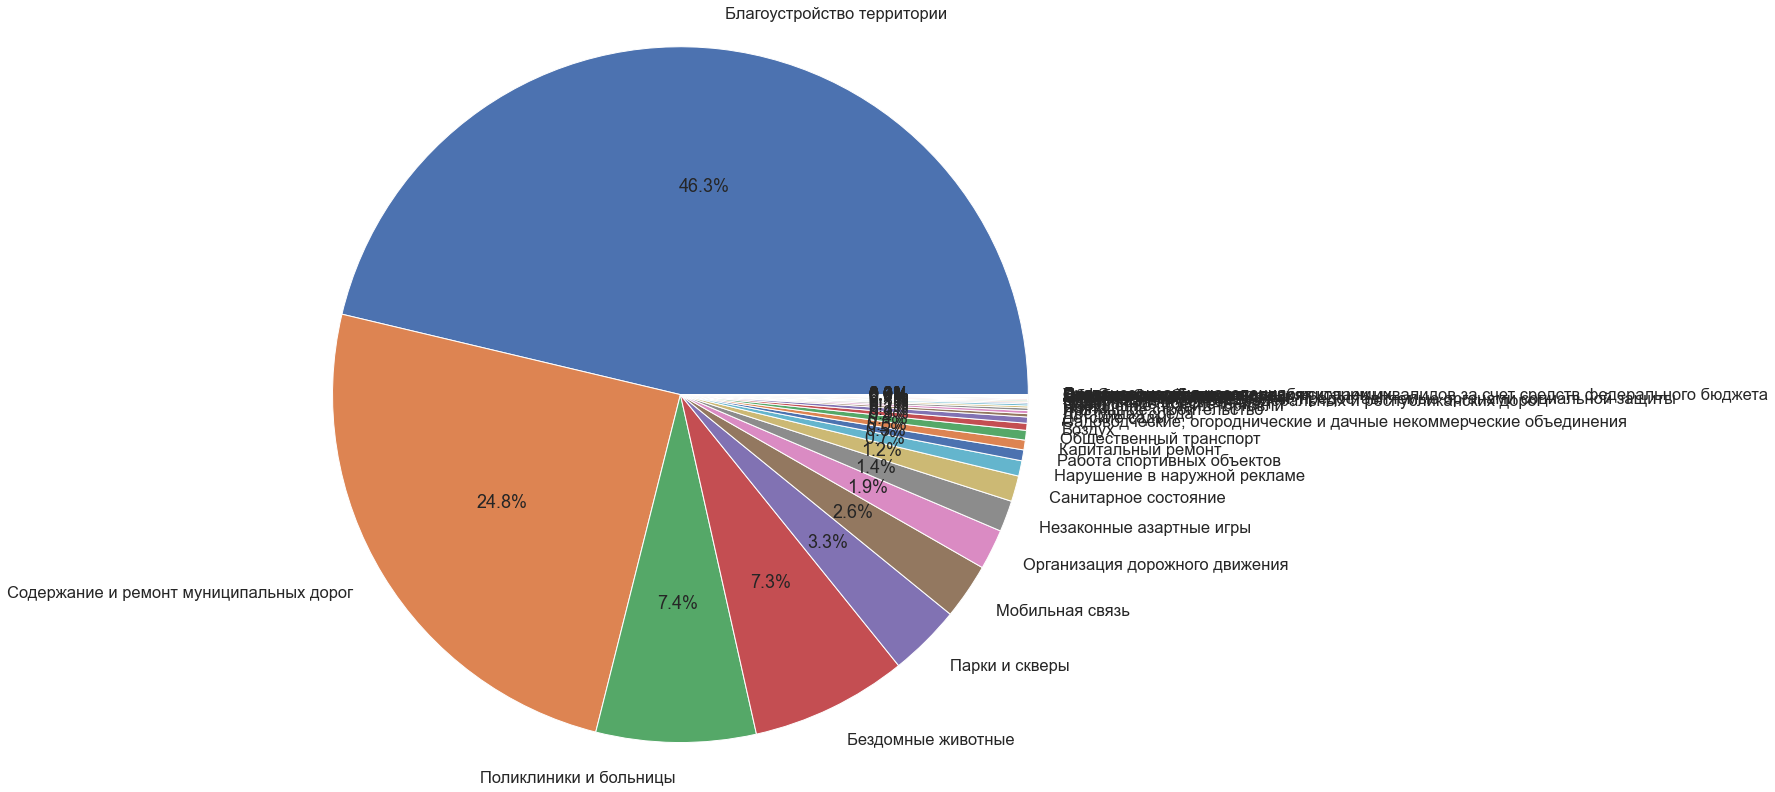

In [259]:
labels = df.category.unique()
values = df.category.value_counts()


mpl.pie(values, labels=labels, radius=4, autopct='%1.1f%%')
pass

Можно увидеть, что имеется большое количество тем обращений, которые составляют менее процента от общего количества, что может плохо повлиять на обучение моделей
Предлагаю отделить все категории, составляющие менее 1% от общего количество обращений в группу "Разное"

Количество уникальных обращений

In [260]:
total_count = df.shape[0]
others_indexes = df.category.value_counts()[df.category.value_counts() < total_count * 0.01].index

Выбор всех категорий, где меньше 25

In [261]:
df.category = df.category.replace(others_indexes, 'Разное')

In [262]:
df.category.value_counts()

Благоустройство территории                 12967
Содержание и ремонт муниципальных дорог     6948
Нарушение в наружной рекламе                2079
Организация дорожного движения              2040
Разное                                      1054
Общественный транспорт                       936
Бездомные животные                           726
Поликлиники и больницы                       524
Парки и скверы                               406
Cвалки                                       335
Name: category, dtype: int64

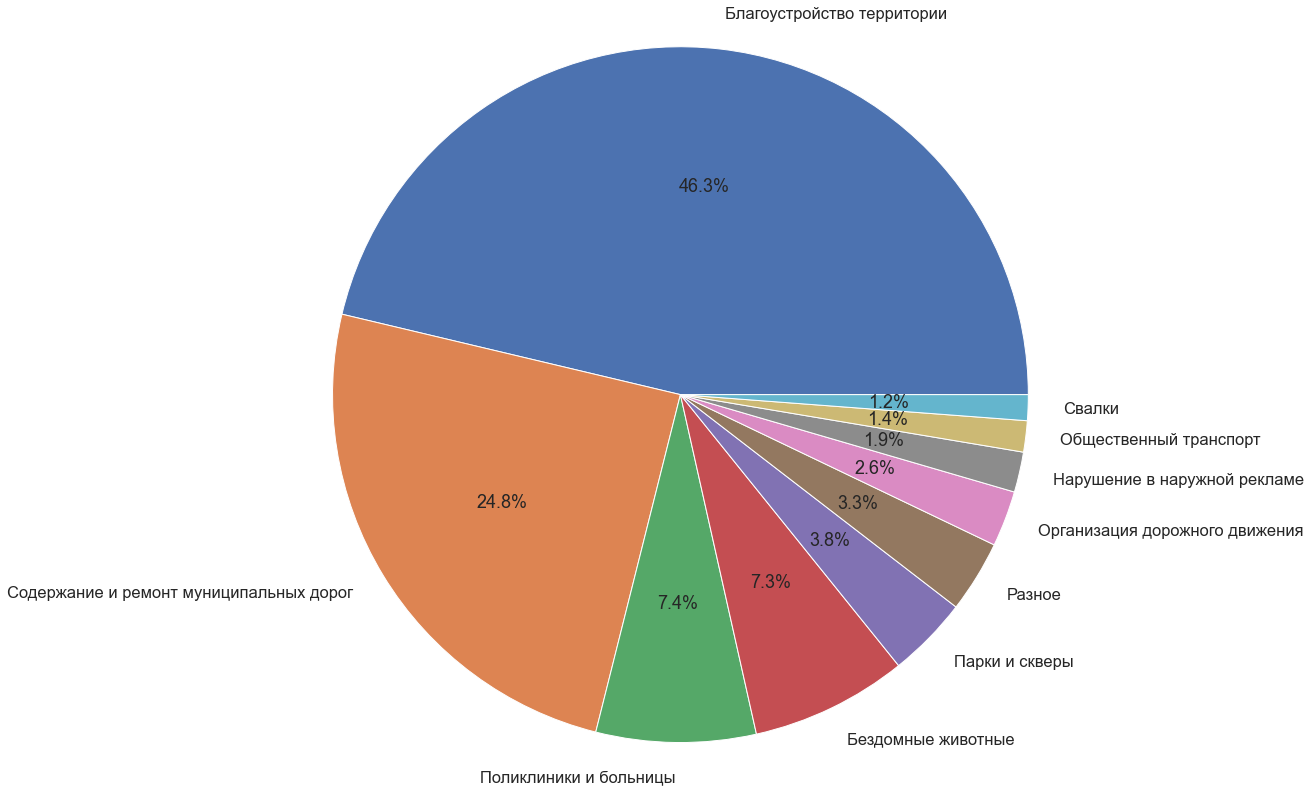

In [263]:
labels = df.category.unique()
values = df.category.value_counts()


mpl.pie(values, labels=labels, radius=4, autopct='%1.1f%%')
pass

Теперь выделяются более явные группы обращений

In [264]:
len(df.category.unique())

10

Удаление стоп-слов

In [265]:
stopwords: WordListCorpusReader = stopwords
all_stopwords = stopwords.words('russian') + ['над']
all_stopwords

['и',
 'в',
 'во',
 'не',
 'что',
 'он',
 'на',
 'я',
 'с',
 'со',
 'как',
 'а',
 'то',
 'все',
 'она',
 'так',
 'его',
 'но',
 'да',
 'ты',
 'к',
 'у',
 'же',
 'вы',
 'за',
 'бы',
 'по',
 'только',
 'ее',
 'мне',
 'было',
 'вот',
 'от',
 'меня',
 'еще',
 'нет',
 'о',
 'из',
 'ему',
 'теперь',
 'когда',
 'даже',
 'ну',
 'вдруг',
 'ли',
 'если',
 'уже',
 'или',
 'ни',
 'быть',
 'был',
 'него',
 'до',
 'вас',
 'нибудь',
 'опять',
 'уж',
 'вам',
 'ведь',
 'там',
 'потом',
 'себя',
 'ничего',
 'ей',
 'может',
 'они',
 'тут',
 'где',
 'есть',
 'надо',
 'ней',
 'для',
 'мы',
 'тебя',
 'их',
 'чем',
 'была',
 'сам',
 'чтоб',
 'без',
 'будто',
 'чего',
 'раз',
 'тоже',
 'себе',
 'под',
 'будет',
 'ж',
 'тогда',
 'кто',
 'этот',
 'того',
 'потому',
 'этого',
 'какой',
 'совсем',
 'ним',
 'здесь',
 'этом',
 'один',
 'почти',
 'мой',
 'тем',
 'чтобы',
 'нее',
 'сейчас',
 'были',
 'куда',
 'зачем',
 'всех',
 'никогда',
 'можно',
 'при',
 'наконец',
 'два',
 'об',
 'другой',
 'хоть',
 'после',
 'на

Фильтруем значения из столбца 'text', чтобы убрать все стоп слова

In [266]:
result_rows = []
for row in df.text:
    filtered_text = []
    for letter in row.split(' '):
        if letter not in all_stopwords:
            filtered_text.append(letter)
    
    result_rows.append((' ').join(filtered_text))
df.text = result_rows

In [267]:
df

,category,text
0,Благоустройство территории,На трассе Нижнекамск-Чистополь лесополосе пгт ...
1,Благоустройство территории,Во дворе дома Ленинградская 29 отсутствуют пар...
2,Содержание и ремонт муниципальных дорог,Добрый день! Не осуществляется уборка снега це...
3,Благоустройство территории,Добрый день! Не осуществляется вывоз мусора те...
4,Содержание и ремонт муниципальных дорог,данном участке проезжей части ул.Халитова дома...
...,...,...
29013,Благоустройство территории,Не производится уборка детской площадке дома 6...
29014,Cвалки,"Свалка отходов, мусора гаражном кооперативе Ав..."
29015,Cвалки,Огромная свалка
29016,Благоустройство территории,"Здравствуйте. Каждый год одно тоже, тех пор на..."


Приводим к нижнему регистру

In [268]:
result_rows = []
for row in df.text:
    result_rows.append(row.lower())
    
df.text = result_rows

In [269]:
df.text.head()

0    на трассе нижнекамск-чистополь лесополосе пгт ...
1    во дворе дома ленинградская 29 отсутствуют пар...
2    добрый день! не осуществляется уборка снега це...
3    добрый день! не осуществляется вывоз мусора те...
4    данном участке проезжей части ул.халитова дома...
Name: text, dtype: object

Удаление всего, кроме букв и оставление одного пробела между слов

In [270]:
patterns = "[^а-яА-Яa-zA-z]+"

patter_spaces = re.compile(r'\s+?|\\')


In [271]:
list = []
for text in df.text:
  buffer = re.sub(patterns, " ", text)
  buffer = re.sub(patter_spaces, " ", buffer)
  list.append(buffer.strip())

df.text = list

In [272]:
df.text

0        на трассе нижнекамск чистополь лесополосе пгт ...
1        во дворе дома ленинградская отсутствуют парков...
2        добрый день не осуществляется уборка снега цен...
3        добрый день не осуществляется вывоз мусора тер...
4        данном участке проезжей части ул халитова дома...
                               ...                        
29013    не производится уборка детской площадке дома к...
29014    свалка отходов мусора гаражном кооперативе авт...
29015                                      огромная свалка
29016    здравствуйте каждый год одно тоже тех пор нача...
29017    в сентябре программе  развитие садоводческого ...
Name: text, Length: 28015, dtype: object

Стемин(оставляем основы слов)

Для более удобного анализа и чтобы не считать одно слова в разных падежах/склонениях разными, оставляем только основы слов

In [273]:
snowball = SnowballStemmer('russian')

In [274]:
def stem(sequence: str) -> str:
  tokens = []
  for token in sequence.split(' '):
    token = snowball.stem(token)
    tokens.append(token)

  if len(tokens) == 0:
    return None
  
  return (" ").join(tokens)

In [275]:
df.text = df.text.apply(stem)

In [276]:
df.text

0        на трасс нижнекамск чистопол лесополос пгт кам...
1        во двор дом ленинградск отсутств парковочн мес...
2        добр ден не осуществля уборк снег центр город ...
3        добр ден не осуществля вывоз мусор территор жи...
4        дан участк проезж част ул халитов дом ул халит...
                               ...                        
29013    не производ уборк детск площадк дом корпус ул ...
29014    свалк отход мусор гаражн кооператив автомобили...
29015                                         огромн свалк
29016    здравств кажд год одн тож тех пор нача привоз ...
29017    в сентябр программ  развит садоводческ движен ...
Name: text, Length: 28015, dtype: object

Разбиение данных

In [277]:
y = df.category
x = df.text

print(y
)

0                     Благоустройство территории
1                     Благоустройство территории
2        Содержание и ремонт муниципальных дорог
3                     Благоустройство территории
4        Содержание и ремонт муниципальных дорог
                          ...                   
29013                 Благоустройство территории
29014                                     Cвалки
29015                                     Cвалки
29016                 Благоустройство территории
29017                 Благоустройство территории
Name: category, Length: 28015, dtype: object


Разбиение данных для обучения и проверки

In [278]:
x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, stratify=y)
x_train = x_train.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
x_test = x_test.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)


Векторизация
Так как алгоритм работает с числами, то нужно превратить последовательности слов в числовые векторные представления

In [279]:
vectorizer = TfidfVectorizer(max_features=10000)


In [280]:
x_train = vectorizer.fit_transform(x_train)
x_test = vectorizer.transform(x_test)

In [281]:
x_test.__str__()

'  (0, 8664)\t0.43451827524707237\n  (0, 8473)\t0.3262162786694052\n  (0, 7431)\t0.47401198422973667\n  (0, 6769)\t0.33429893564277174\n  (0, 4146)\t0.6069049912812484\n  (1, 9912)\t0.1994223119753954\n  (1, 9292)\t0.36822528725670767\n  (1, 9225)\t0.2099686460936367\n  (1, 8699)\t0.2026130377327888\n  (1, 8697)\t0.10495754505148348\n  (1, 8509)\t0.11233345971934941\n  (1, 7499)\t0.22056132597023106\n  (1, 6758)\t0.2837094006740456\n  (1, 6602)\t0.20009086620181318\n  (1, 6060)\t0.14521629227589264\n  (1, 6042)\t0.18087256720978606\n  (1, 6027)\t0.14637252933852485\n  (1, 5150)\t0.1353921802147646\n  (1, 5072)\t0.14113118138275405\n  (1, 4824)\t0.35299203687469227\n  (1, 4449)\t0.14000924488025762\n  (1, 4336)\t0.20009086620181318\n  (1, 3696)\t0.10070021105827584\n  (1, 3584)\t0.19876798339198742\n  (1, 3575)\t0.15502365951514904\n  :\t:\n  (5602, 8903)\t0.14046580936963324\n  (5602, 8697)\t0.10055956874206452\n  (5602, 8673)\t0.1866602759446997\n  (5602, 8509)\t0.10762641465309492\n 

## Обучение

Отображение точности предсказания 

In [282]:
def confuse(y_text, y_predicted): 
    sb.heatmap(confusion_matrix(y_text, y_predicted),annot=True, fmt='.0f' )

### Скалярные вектора

Ипользование метода скалярных векторов для работы с векторами

In [283]:
svc = SVC(kernel='linear', C=1)

In [284]:
svc.fit(x_train, y_train)

SVC(C=1, kernel='linear')

In [285]:
svc.score(x_test, y_test)

0.8358022487952882

In [286]:
y_predicted = svc.predict(x_test)

In [287]:
accuracy_score(y_test, y_predicted)

0.8358022487952882

In [288]:
print(classification_report(y_test, y_predicted))

                                         precision    recall  f1-score   support

                                 Cвалки       0.62      0.37      0.47        67
                     Бездомные животные       0.96      0.96      0.96       145
             Благоустройство территории       0.82      0.88      0.85      2593
           Нарушение в наружной рекламе       0.91      0.89      0.90       416
                 Общественный транспорт       0.94      0.81      0.87       187
         Организация дорожного движения       0.85      0.80      0.82       408
                         Парки и скверы       0.62      0.35      0.44        81
                 Поликлиники и больницы       0.94      0.83      0.88       105
                                 Разное       0.94      0.53      0.67       211
Содержание и ремонт муниципальных дорог       0.81      0.84      0.83      1390

                               accuracy                           0.84      5603
                          

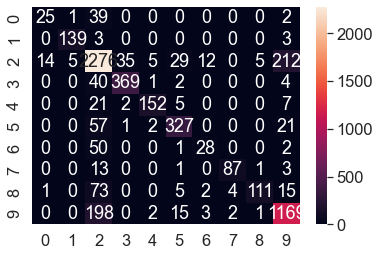

In [289]:
confuse(y_test, y_predicted)

Модель показала себя довольно хорошо, имея средний показатель в 79 процент, но все равно это не достаточно точная модель

In [290]:
f1_svc = f1_score(y_test,y_predicted, average='macro')

### Случайный лес

In [291]:
forest = RandomForestClassifier(n_estimators=300)

In [292]:
forest.fit(x_train, y_train)

RandomForestClassifier(n_estimators=300)

In [293]:
y_predicted = forest.predict(x_test)

In [294]:
f1_rf = f1_score(y_test,y_predicted, average='macro')

In [295]:
print(classification_report(y_test, y_predicted))

                                         precision    recall  f1-score   support

                                 Cвалки       0.72      0.34      0.46        67
                     Бездомные животные       0.98      0.96      0.97       145
             Благоустройство территории       0.82      0.87      0.84      2593
           Нарушение в наружной рекламе       0.89      0.89      0.89       416
                 Общественный транспорт       0.88      0.79      0.83       187
         Организация дорожного движения       0.83      0.79      0.81       408
                         Парки и скверы       0.70      0.20      0.31        81
                 Поликлиники и больницы       0.89      0.78      0.83       105
                                 Разное       0.97      0.41      0.57       211
Содержание и ремонт муниципальных дорог       0.78      0.84      0.81      1390

                               accuracy                           0.82      5603
                          

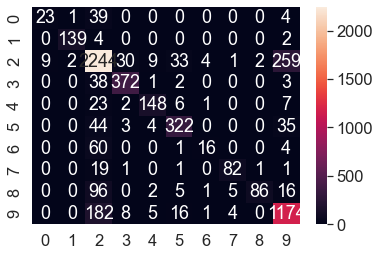

In [296]:
confuse(y_test, y_predicted)

Модель случайного леса показывает себя чуть хуже, чем метод скалярных векторов. Ее средний показатель равен 75%

### Соседи

In [297]:
neighbors = KNeighborsClassifier()
neighbors.fit(x_train, y_train)
y_predicted = neighbors.predict(x_test)

In [298]:
f1_kn = f1_score(y_test,y_predicted, average='macro')

In [299]:
print(classification_report(y_test, y_predicted))

                                         precision    recall  f1-score   support

                                 Cвалки       0.55      0.36      0.43        67
                     Бездомные животные       0.97      0.19      0.32       145
             Благоустройство территории       0.61      0.52      0.56      2593
           Нарушение в наружной рекламе       0.14      0.91      0.24       416
                 Общественный транспорт       0.79      0.12      0.20       187
         Организация дорожного движения       0.71      0.26      0.38       408
                         Парки и скверы       0.00      0.00      0.00        81
                 Поликлиники и больницы       1.00      0.01      0.02       105
                                 Разное       0.83      0.07      0.13       211
Содержание и ремонт муниципальных дорог       0.78      0.19      0.31      1390

                               accuracy                           0.39      5603
                          

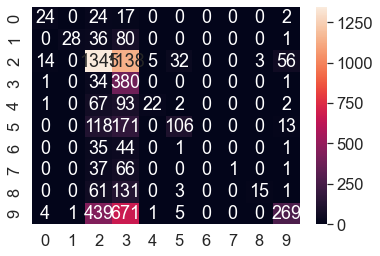

In [300]:
confuse(y_test, y_predicted)

Модель с соседями показала себя хуже всего, этот метод близко к "пальцем в небо"

Сравним точность предсказания моделей. Для этого выберем barplot, потому что он помогает изобразить велечину и отношение величин

<AxesSubplot:>

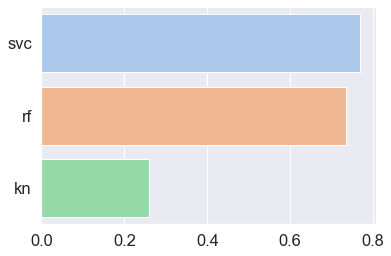

In [301]:
sb.set(font_scale=1.5)
# f, ax = mpl.subplots(figsize=(10, 5))
sb.barplot(y=['svc', 'rf', 'kn'], x=[f1_svc, f1_rf, f1_kn],
           palette='pastel', orient='h')


Из графика можно учидеть, что модель скалярных векторов лучше всего подходит для работы с текстом и предсказаения мнений

# Итог

Для предсказания категории обращения лучше всего использовать модель скалярных векторов, так как по всем показателям она превосходит остальные модели

# GUI

In [337]:
from tkinter import *



root = Tk()

root.title('Gui')

frame = Frame(root)
frame.grid()


label = Label(frame, text='Label').grid(row=1)
button = Button(frame, text='Button').grid(row=2)





In [338]:

root.mainloop()